In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Custom Dataset dari path
class FolderImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = 0  # Dummy label (semua 0)
        return image, label

# Path ke folder
image_dir = '/content/drive/MyDrive/B_23'

# Dataset dan DataLoader
dataset = FolderImageDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Tes ambil batch
images, labels = next(iter(dataloader))
print(f"Jumlah batch: {len(dataloader)}")
print(f"Bentuk batch: {images.shape}")


Jumlah batch: 34
Bentuk batch: torch.Size([32, 3, 100, 100])


# EDA

In [ ]:
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Total gambar: {len(image_files)}")


Total gambar: 1074


Mencari banyaknya gambar yang kali ini digunakan

In [ ]:
sizes = []
modes = []

for fname in image_files:
    img_path = os.path.join(image_dir, fname)
    with Image.open(img_path) as img:
        sizes.append(img.size)  # (width, height)
        modes.append(img.mode)  # RGB, L, etc.

# Ukuran paling umum
from collections import Counter
print("Ukuran paling sering:", Counter(sizes).most_common(1))
print("Mode warna:", set(modes))


Ukuran paling sering: [((600, 600), 1074)]
Mode warna: {'RGB'}


Untuk melihat apakah size gambar yang digunakan sudah pas atau aman jika hendak digunakan untuk modeling

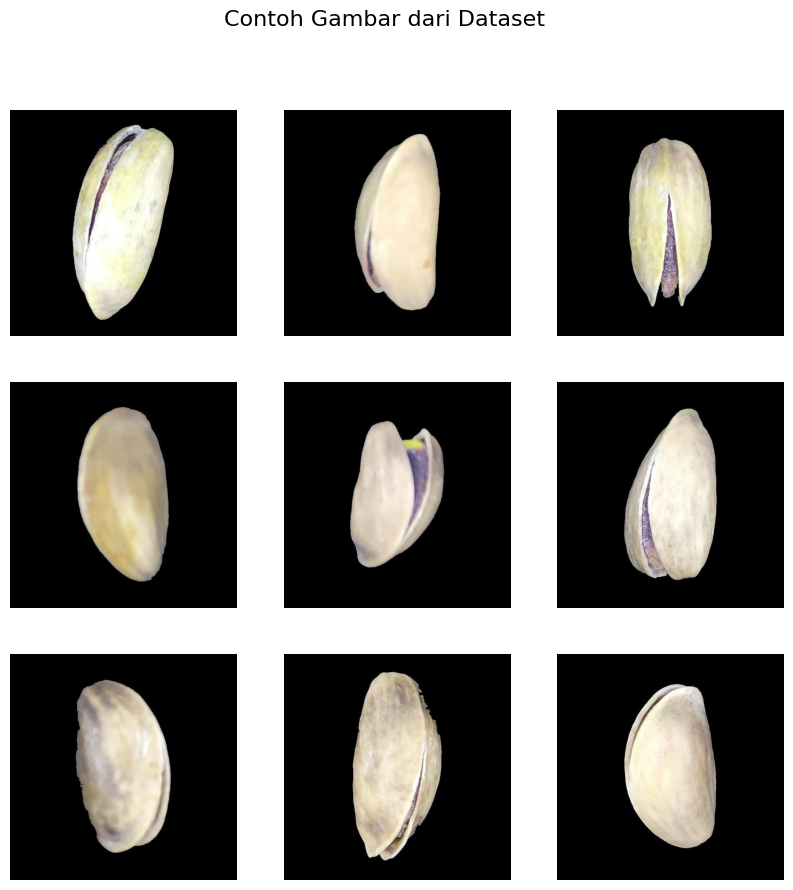

In [ ]:
import matplotlib.pyplot as plt

n = 9
plt.figure(figsize=(10, 10))
for i in range(n):
    img_path = os.path.join(image_dir, image_files[i])
    img = Image.open(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Dataset", fontsize=16)
plt.show()


Mencari tau data apa yang akan digunakan

        width  height
count  1074.0  1074.0
mean    600.0   600.0
std       0.0     0.0
min     600.0   600.0
25%     600.0   600.0
50%     600.0   600.0
75%     600.0   600.0
max     600.0   600.0


<Axes: title={'center': 'Distribusi Ukuran Gambar'}, ylabel='Frequency'>

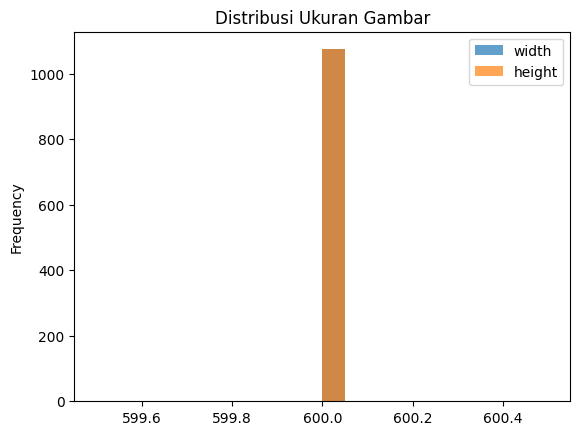

In [ ]:
import pandas as pd

widths = [w for (w, h) in sizes]
heights = [h for (w, h) in sizes]

df_size = pd.DataFrame({'width': widths, 'height': heights})
print(df_size.describe())

# Visualisasi
df_size.plot(kind='hist', bins=20, title='Distribusi Ukuran Gambar', alpha=0.7)


Melihat distribusi gambar apakah ada yang berbeda atau semuanya sama, jika ada yang berbeda maka akan diubah menjadi ukuran yang sama untuk tiap gambar

In [ ]:
import hashlib

hashes = set()
duplicates = 0

for fname in image_files:
    path = os.path.join(image_dir, fname)
    with open(path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash in hashes:
            duplicates += 1
        else:
            hashes.add(file_hash)

print(f"Duplikat gambar terdeteksi: {duplicates}")


Duplikat gambar terdeteksi: 0


Mencari tau apakah ada gambar yang sama (duplicate), dimana pada kali ini gambar duplicatenya berjumlah 10

In [ ]:
import numpy as np
bad_files = []
for fname in image_files:
    try:
        Image.open(os.path.join(image_dir, fname)).verify()
    except:
        bad_files.append(fname)

print(f"Gambar rusak: {len(bad_files)}")


Gambar rusak: 0


Check apakah ada gambar yang mengalami rusak yang akan menyebabkan model yang kita bangun menjadi bermasalah.

# Cleaning data dan preprocessing

In [ ]:
def find_duplicates(folder_path):
    hashes = {}
    duplicates = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('jpg', 'png', 'jpeg')):
            filepath = os.path.join(folder_path, filename)
            with open(filepath, 'rb') as f:
                filehash = hashlib.md5(f.read()).hexdigest()
            if filehash in hashes:
                duplicates.append(filepath)
            else:
                hashes[filehash] = filepath
    return duplicates

duplicates = find_duplicates(image_dir)


# Hapus duplikat
for f in duplicates:
    os.remove(f)

In [ ]:
class NoisyImageDataset(Dataset):
    def __init__(self, image_paths, transform=None, add_noise=False, noise_std=0.1):
        self.image_paths = image_paths
        self.transform = transform
        self.add_noise = add_noise
        self.noise_std = noise_std

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        clean = image.clone()

        if self.add_noise:
            noise = torch.normal(mean=0.0, std=self.noise_std, size=image.size())
            image = image + noise
            image = torch.clamp(image, 0., 1.)

        return image, clean  # noisy image → input, clean image → target


In [ ]:
from sklearn.model_selection import train_test_split
image_paths = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Split 80% train, 10% val, 10% test
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
val_paths, test_paths   = train_test_split(test_paths, test_size=0.5, random_state=42)

print(f"Train : {len(train_paths)}\nVal   : {len(val_paths)}\nTest  : {len(test_paths)}")


Train : 859
Val   : 107
Test  : 108


In [ ]:
batch_size = 32

train_dataset = NoisyImageDataset(train_paths, transform=transform, add_noise=True)
val_dataset   = NoisyImageDataset(val_paths,   transform=transform, add_noise=True)
test_dataset  = NoisyImageDataset(test_paths,  transform=transform, add_noise=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
# Check size
images_size,labels = next(iter(dataloader))
print(images_size.shape)


torch.Size([32, 3, 100, 100])


# Modeling

## Baseline model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, InputLayer
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),    # (100, 100, 3) -> (100, 100, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                            # -> (50, 50, 32)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # -> (50, 50, 64)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                            # -> (25, 25, 64)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),   # -> (25, 25, 64)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),   # -> (50, 50, 64)
            nn.Conv2d(64, 32, kernel_size=3, padding=1),   # -> (50, 50, 32)
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),   # -> (100, 100, 32)
            nn.Conv2d(32, 3, kernel_size=3, padding=1),    # -> (100, 100, 3)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [ ]:
import torch.optim as optim

# Inisialisasi model dan perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

# Loss dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Jumlah epoch
n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:  # input = noisy, target = clean
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d}/{n_epochs} | Train Loss: {epoch_loss:.6f}")


Epoch 01/20 | Train Loss: 0.069078
Epoch 02/20 | Train Loss: 0.003027
Epoch 03/20 | Train Loss: 0.002244
Epoch 04/20 | Train Loss: 0.002182
Epoch 05/20 | Train Loss: 0.001802
Epoch 06/20 | Train Loss: 0.001489
Epoch 07/20 | Train Loss: 0.001388
Epoch 08/20 | Train Loss: 0.001384
Epoch 09/20 | Train Loss: 0.001227
Epoch 10/20 | Train Loss: 0.001122
Epoch 11/20 | Train Loss: 0.001043
Epoch 12/20 | Train Loss: 0.001114
Epoch 13/20 | Train Loss: 0.000918
Epoch 14/20 | Train Loss: 0.000871
Epoch 15/20 | Train Loss: 0.000841
Epoch 16/20 | Train Loss: 0.000816
Epoch 17/20 | Train Loss: 0.000814
Epoch 18/20 | Train Loss: 0.000785
Epoch 19/20 | Train Loss: 0.000756
Epoch 20/20 | Train Loss: 0.000768


Hasil training loss dengan melakukan 20 epoch, hal yang kita bisa lihat bahwa model sudah dengan baik belajar pola yang pada data. Dengan diikuti beberapa hal ini:

Pada awal kali (epoch pertama), loss menunjukkan di angka (0.069), yang menyatakan bahwa model awalnya masih belum mengenali pola dengan baik.

Setelah itu, loss mulai menurun drastis di epoch kedua menjadi 0.0030 dan terus berkurang secara bertahap di epoch-epoch selanjutnya.

Tepat pada epoch terakhir(epoch 20), angka loss turun mencapai sekitar 0.00076, yang menyatakan bahwa model sudah mampu merekonstruksi gambar bersih dari gambar noisy dengan baik.

Kesimpulan:
Model berhasil belajar dan beradaptasi dengan data, dengan performa meningkat stabil sepanjang epoch tanpa tanda-tanda overfitting.

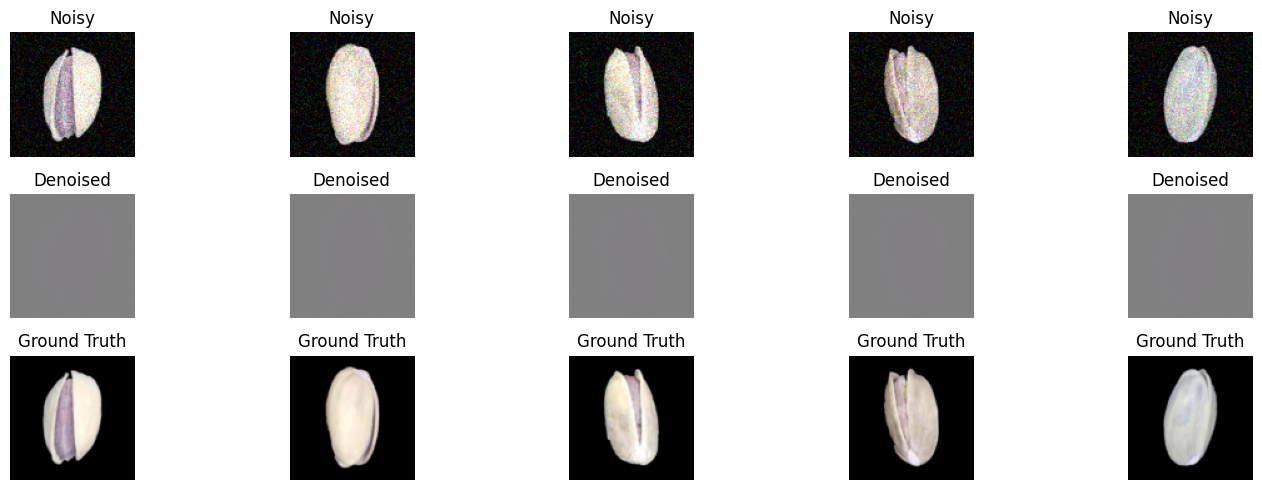

In [ ]:
# Define device dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

model.eval()

# Ambil satu batch dari test_loader
noisy_imgs, clean_imgs = next(iter(test_loader))
noisy_imgs  = noisy_imgs.to(device)
clean_imgs  = clean_imgs.to(device)

# Forward pass (tanpa grad karena evaluasi)
with torch.no_grad():
    outputs = model(noisy_imgs)

# Fungsi bantu untuk menampilkan gambar
def show_images(inputs, outputs, targets, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Noisy image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(inputs[i].cpu().permute(1, 2, 0))
        plt.title("Noisy")
        plt.axis("off")

        # Output (denoised)
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(outputs[i].cpu().permute(1, 2, 0))
        plt.title("Denoised")
        plt.axis("off")

        # Ground Truth
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(targets[i].cpu().permute(1, 2, 0))
        plt.title("Ground Truth")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Tampilkan hasil
show_images(noisy_imgs, outputs, clean_imgs, n=5)


## Modifikasi model

In [ ]:
class ModifiedAutoencoder(nn.Module):
    def __init__(self):
        super(ModifiedAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # [B, 3, 100, 100] → [B, 32, 100, 100]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # → [B, 32, 50, 50]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # → [B, 64, 50, 50]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # → [B, 64, 25, 25]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),  # → [B, 64, 50, 50]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # → [B, 32, 100, 100]
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),           # → [B, 3, 100, 100]
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Inisialisasi perangkat & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedAutoencoder().to(device)

# Loss function dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Jumlah epoch
n_epochs = 20

# Mulai training
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy_imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:02d}/{n_epochs} | Train Loss: {epoch_loss:.6f}")

Epoch 01/20 | Train Loss: 0.107813
Epoch 02/20 | Train Loss: 0.003005
Epoch 03/20 | Train Loss: 0.001670
Epoch 04/20 | Train Loss: 0.001396
Epoch 05/20 | Train Loss: 0.001290
Epoch 06/20 | Train Loss: 0.001236
Epoch 07/20 | Train Loss: 0.001153
Epoch 08/20 | Train Loss: 0.001086
Epoch 09/20 | Train Loss: 0.000951
Epoch 10/20 | Train Loss: 0.000965
Epoch 11/20 | Train Loss: 0.000885
Epoch 12/20 | Train Loss: 0.000839
Epoch 13/20 | Train Loss: 0.000837
Epoch 14/20 | Train Loss: 0.000880
Epoch 15/20 | Train Loss: 0.000761
Epoch 16/20 | Train Loss: 0.000730
Epoch 17/20 | Train Loss: 0.000763
Epoch 18/20 | Train Loss: 0.000756
Epoch 19/20 | Train Loss: 0.000780
Epoch 20/20 | Train Loss: 0.000706


Hasil training loss dengan melakukan 20 epoch, hal yang kita bisa lihat bahwa model sudah dengan baik belajar pola yang pada data. Dengan diikuti beberapa hal ini:

Pada awal kali (epoch pertama), loss menunjukkan di angka (0.107813), yang menyatakan bahwa model awalnya masih belum mengenali pola dengan baik.

Setelah itu, loss mulai menurun drastis di epoch kedua menjadi 0.003005 dan terus berkurang secara bertahap di epoch-epoch selanjutnya.

Tepat pada epoch terakhir(epoch 20), angka loss turun mencapai sekitar 0.00076, yang menyatakan bahwa model sudah mampu merekonstruksi gambar bersih dari gambar noisy dengan baik.

Kesimpulan:
Model berhasil belajar dan beradaptasi dengan data, dengan performa meningkat stabil sepanjang epoch tanpa tanda-tanda overfitting.

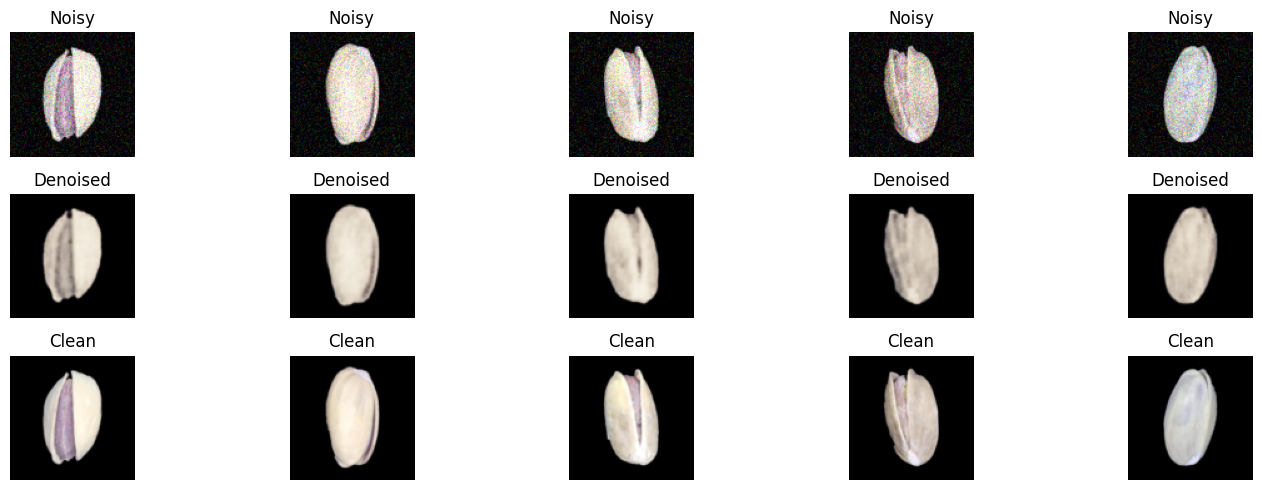

In [ ]:
# Set model ke eval mode
model.eval()

# Ambil 1 batch dari test_loader
noisy_imgs, clean_imgs = next(iter(test_loader))
noisy_imgs = noisy_imgs.to(device)
clean_imgs = clean_imgs.to(device)

# Prediksi hasil denoising
with torch.no_grad():
    outputs = model(noisy_imgs)

# Pindahkan ke CPU & ubah ke numpy
noisy_imgs  = noisy_imgs.cpu().numpy()
clean_imgs  = clean_imgs.cpu().numpy()
outputs     = outputs.cpu().numpy()

# Tampilkan 5 gambar: noisy, prediksi, dan asli
n = 5
plt.figure(figsize=(15, 5))
for i in range(n):
    # Gambar Noisy
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_imgs[i].transpose(1, 2, 0))
    plt.title("Noisy")
    plt.axis("off")

    # Gambar Output (Denoised)
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(outputs[i].transpose(1, 2, 0))
    plt.title("Denoised")
    plt.axis("off")

    # Gambar Asli (Clean)
    plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(clean_imgs[i].transpose(1, 2, 0))
    plt.title("Clean")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Evaluasi model

In [ ]:
from skimage.metrics import structural_similarity as ssim

def evaluate_ssim(model, dataloader, device):
    model.eval()
    ssim_scores = []

    with torch.no_grad():
        for noisy_imgs, clean_imgs in dataloader:
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            outputs = model(noisy_imgs)

            for out_img, gt_img in zip(outputs, clean_imgs):
                out_np = out_img.permute(1, 2, 0).cpu().numpy()  # [C, H, W] → [H, W, C]
                gt_np  = gt_img.permute(1, 2, 0).cpu().numpy()

                score = ssim(
                    gt_np,
                    out_np,
                    data_range=1.0,
                    channel_axis=-1  # penting untuk gambar RGB
                )
                ssim_scores.append(score)

    return np.mean(ssim_scores)

In [ ]:
# Inisialisasi model (pastikan sudah di-train sebelumnya)
model_baseline = Autoencoder().to(device)
model_modifikasi = ModifiedAutoencoder().to(device)

# Evaluasi SSIM
ssim_base = evaluate_ssim(model_baseline, test_loader, device)
ssim_mod  = evaluate_ssim(model_modifikasi, test_loader, device)

print(f"Baseline SSIM    : {ssim_base:.4f}")
print(f"Modifikasi SSIM  : {ssim_mod:.4f}")


Baseline SSIM    : 0.0856
Modifikasi SSIM  : 0.0846


Hasil evaluasi SSIM menunjukkan bahwa perfoma baseline model (0.0856) sedikit lebih baik ketimbang dengan model modifikasi (0.0846) dalam melakukan rekrontruksi gambar yang mirip secara struktur dengan aslinya. Selisihnya sangat kecil, yang menandakan bahwa performa keduanya hampir setara. Nilai SSIM yang rendah mengindikasikan model belum optimal, dan masih bisa ditingkatkan dengan tuning lebih lanjut.

# LINK VIDEO:

https://drive.google.com/drive/folders/1yWCgGCAcEFNAKjsQ7pFCG17R5ox9kW5L?usp=drive_link